### Forex Effects on Crypto Markets - Arbitrage Exploration
**Status:** Incomplete - Revisit in the future<br />
**Author:** Gerardo Salazar <br />
**Date:** 2018-04-19 14:46:30
<hr />
We believe that arbitrage opportunities exist in the cryptocurrency markets as a result of FOREX currency fluctuations. Without the ability to trade both currencies at once, and lack of shorting on the GDAX exchange, we introduce a variety of constraints that prevent traditional market-neutral strategies from functioning. As a result, we will consider market-making strategies with an emphasis on managing inventory-risk to generate abnormal profits.

In [1]:
%matplotlib inline

from clr import AddReference
AddReference("System")
AddReference("QuantConnect.Common")
AddReference("QuantConnect.Jupyter")
AddReference("QuantConnect.Indicators")
from System import *
from QuantConnect import *
from QuantConnect.Data.Custom import *
from QuantConnect.Data.Market import TradeBar, QuoteBar
from QuantConnect.Jupyter import *
from QuantConnect.Indicators import *

import os
import sys

import talib
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pykalman as kf
import statsmodels.api as sm
import statsmodels
import sklearn
import requests
import quandl
import time

from scipy.stats import jarque_bera
from scipy.signal import correlate
from datetime import datetime, timedelta
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/opt/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [71]:
#mpl.rcParams['figure.dpi'] = 15 # Higher quality graphs
plt.rcParams['figure.figsize'] = [15, 8] # Wider graphs

In [72]:
# For each cryptocurrency being traded on GDAX, we will gather two pairs to represent both markets.
RESOLUTION = Resolution.Minute
START = datetime(2018,4,1)
END = datetime(2018,4,16)

qb = QuantBook()

qb.AddCrypto('BTCUSD')
qb.AddCrypto('BTCEUR')
qb.AddCrypto('ETHUSD')
qb.AddCrypto('ETHEUR')
qb.AddCrypto('LTCUSD')
qb.AddCrypto('LTCEUR')

# We call unstack to shuffle the asset names into columns and timestamps to index
history_minute = qb.History(qb.Securities.Keys, START, END, RESOLUTION).unstack(level=0)
history_minute.index = pd.to_datetime(history_minute.index, utc=True).tz_localize(None)

qb = QuantBook() # Redeclare to get FOREX data
qb.AddForex('EURUSD') # QuantBook doesn't behave nicely with two different asset classes in the same call
history_eur = qb.History(qb.Securities.Keys, START, END, RESOLUTION).unstack(level=0)
history_eur.index = pd.to_datetime(history_eur.index, utc=True).tz_localize(None)

# Join the two datasets to create a unified DataFrame with the same index
hist_join = history_minute.join(history_eur[['open', 'close']]).fillna(method='ffill').dropna() # This joins the FOREX DataFrame and the Crypto DF

In [73]:
# Consolidate the data into usable formats

euro_assets = ['BTCEUR', 'LTCEUR', 'ETHEUR']
usd_assets = ['BTCUSD', 'LTCUSD', 'ETHUSD']

asset_eur = hist_join['close'][[asset for asset in euro_assets]]
asset_usd = hist_join['close'][[asset for asset in usd_assets]]

We will convert our $\frac{F_2}{C_1}$ data into $\frac{F_1}{C_1}$, where $F_1, F_2 = \text{FOREX (EUR//USD)}$

It can easily be accomplished by merely multiplying the $\frac{F_2}{C_1}$ time series by $\frac{F_1}{F_2}$.
More formally, the formula is $\frac{F_1 F_2}{F_2 C_1} = \frac{F_1}{C_1}$

In [74]:
asset_eur_converted = asset_eur.mul(hist_join['close']['EURUSD'], axis=0)
asset_eur_converted.columns = asset_usd.columns # Set the columns equal to each other to make for easy calculations

Because we want the difference in spread between our two currencies, we will just save it as a simple percentage differential from each other. Ideally, any spread $-0.0060 < n < 0.0060$ is profitable via market order. But because GDAX offers 0.00% market making fees, any spread that exists between $F_1$ $F_2$ crypto asset pairs can be arbitraged away, ideally, by a market making bot.

In [75]:
# We ensure like this that if F_1 C_1 is overpriced, it is a positive value, and vice versa
asset_spread = (asset_usd - asset_eur_converted) / asset_eur_converted

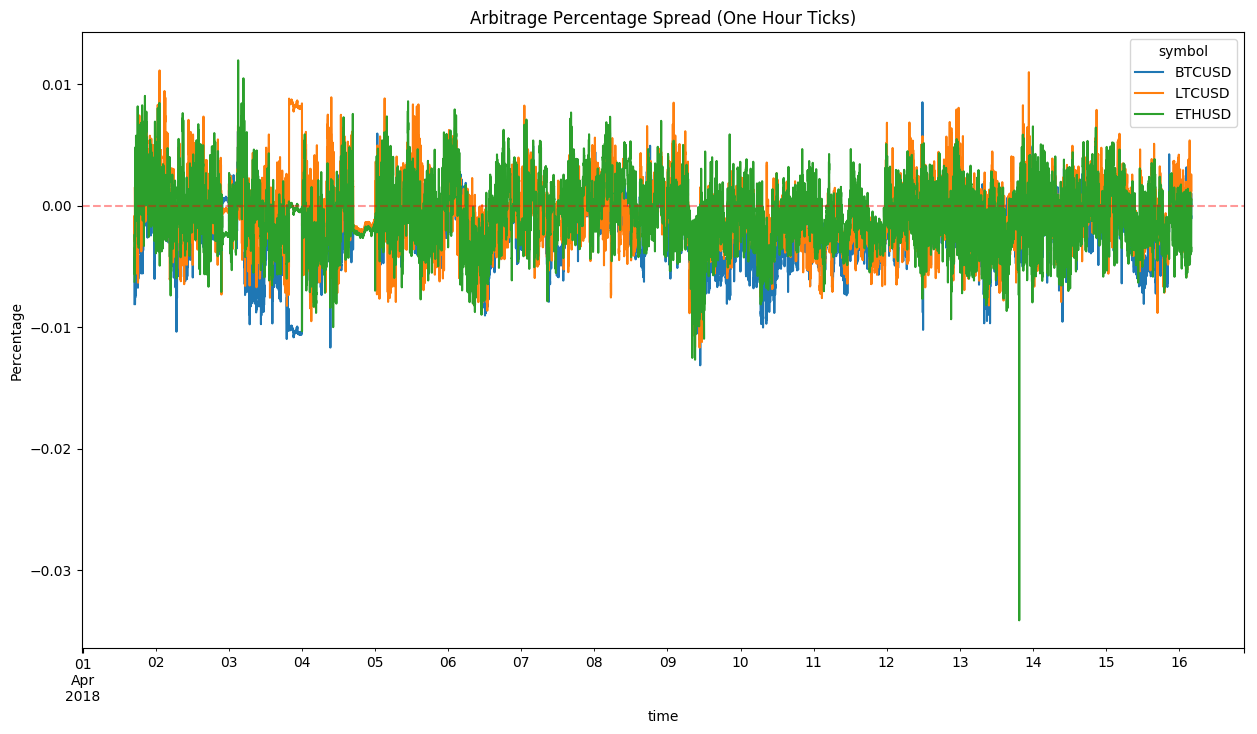

In [76]:
asset_spread.plot()
plt.title('Arbitrage Percentage Spread (One Hour Ticks)')
plt.ylabel('Percentage')
plt.axhline(0.0, c='#ff0000', alpha=0.4, linestyle='--')

In [77]:
assets = asset_spread.join(asset_usd.pct_change(), lsuffix='_spread').dropna()

spread_col = assets.columns[0:3]
asset_col = assets.columns[3:]

Let's inspect the distribution of the spreads to see if anything might be amiss...

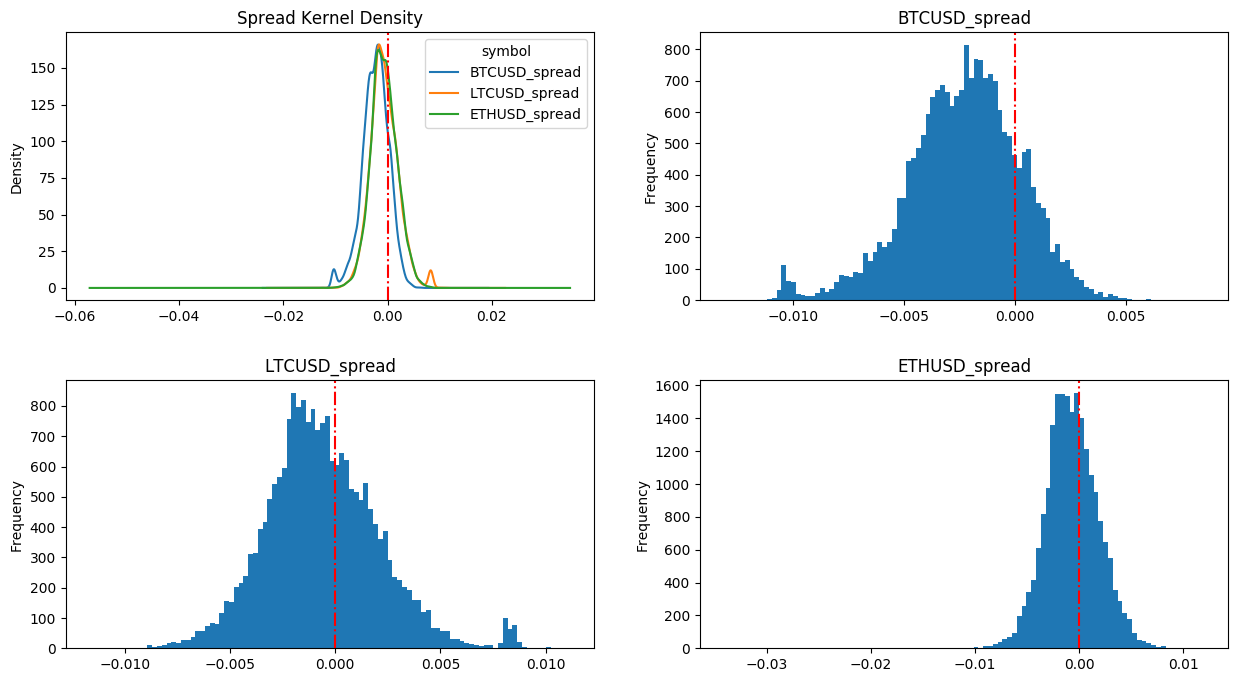

In [78]:
fig, ax = plt.subplots(2,2)
fig.subplots_adjust(hspace=.3)

assets[spread_col].plot.kde(ax=ax[0,0], title='Spread Kernel Density')
ax[0,0].axvline(0.00, c='#ff0000', linestyle='-.')

ax_row = 0
ax_col = 1

for col in spread_col:
    assets[col].plot(kind='hist', bins=100, ax=ax[ax_row, ax_col], title=col)
    ax[ax_row, ax_col].axvline(0.00, c='#ff0000', linestyle='-.')
    
    ax_col += 1
    
    if ax_col % 2 == 0:
        ax_col = 0
        ax_row += 1

plt.show()

Let's get the half-life of these pairs. The half-life is a measure of how long it takes the spread to revert to the mean. It is derived from the Ornstein-Uhlenbeck<sup>[[1]](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process)</sup> equation

In [79]:
def get_half_life(df, col='spread', lag=1, sigfigs=5): 
    # To get the half life of the mean reversion series, we apparently have to create a 
    # lagged version of our time series, and run an OLS test on it. We then get the Beta
    # and use it in the Ornstein-Uhlenbeck equations to determine the half-life.

    # This returns an unusable first entry. Filter it out
    spread_lag = df[col].shift(lag).iloc[lag:]

    # Make data the same shape, and calculate the return from the original vs. lagged period
    spread_return = df[col].iloc[lag:] - spread_lag

    # Adds a bunch of 1's into the DataFrame. I don't know why this is needed *-*
    sl2 = sm.add_constant(spread_lag)

    # Run Ordinary Least Squares (OLS) and fit the data
    result = sm.OLS(spread_return, sl2).fit()

    # Extract the value we're after
    beta = result.params[1]
    
    # return half-life of our mean reverting process
    return round(-np.log(2) / beta, sigfigs)

In [80]:
half_lives = {}

for coin in asset_col:
    half_lives['%s_spread' % coin] = get_half_life(assets, col='%s_spread' % coin, lag=1, sigfigs=16)

In [81]:
half_lives

{'BTCUSD_spread': 11.052560837282517,
 'ETHUSD_spread': 4.5782223902519128,
 'LTCUSD_spread': 5.9336423952776238}

The `BTC` asset pair has a half-life of approximately $11.05$, which indicates that it takes about 11 minutes to revert to its mean, aka properly arbitraged. Now, we need to be able to identify profitable trades to make this research worthwile. It is worth noting (from my personal experience watching the markets) that just because there exists a wide spread between the two asset pairs, doesn't mean we can profit from them. Sometimes, the pair is trending downwards and is very risky to attempt an arbitrage.

Without the ability to short on GDAX, we are left dead in the water when it comes to avoiding market risk. Because of this, we must be very careful when we choose to take an arbitrage opportunity. In this scenario, we could potentially use machine learning, but I don't know how to use it yet, and I'm sure it can be done without it as well.

Let's begin by identifying the standard deviation of the dataset, then setting off a cutoff point that we would be willing to consider/take for our arbitrage opportunities. Afterwards, we will do some analysis on the factors that could affect the pair and look for other miscellaneous factors that could aid us in predicting direction/making profit.

In [82]:
std_filter = 2 * assets[spread_col].std()
std_spread = assets#assets[spread_col][(assets[spread_col] < -std_filter)]# | (assets[spread_col] > std_filter)]

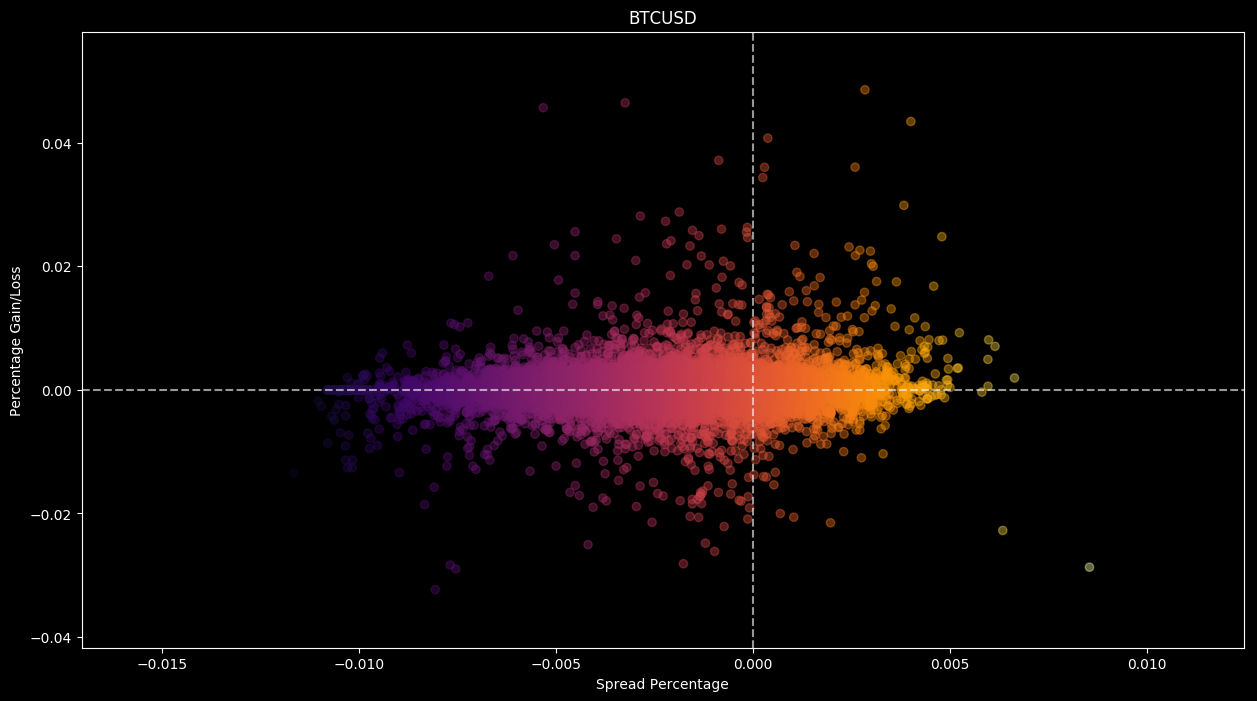

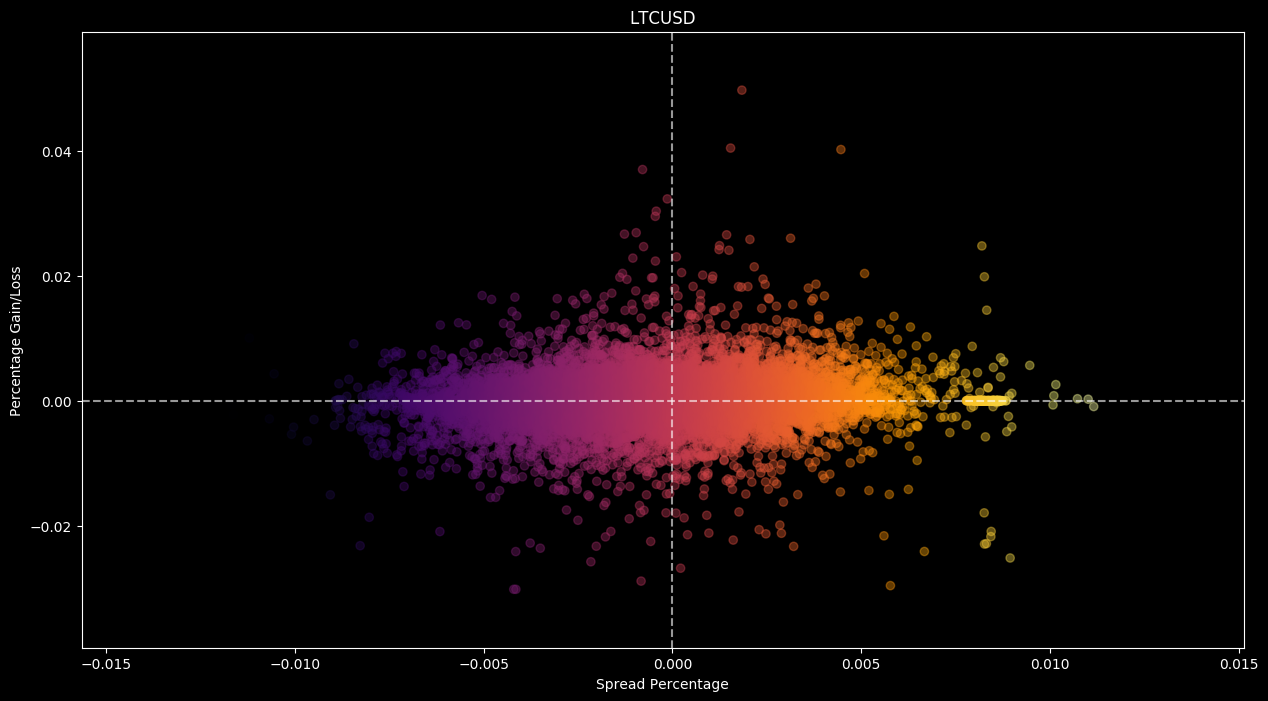

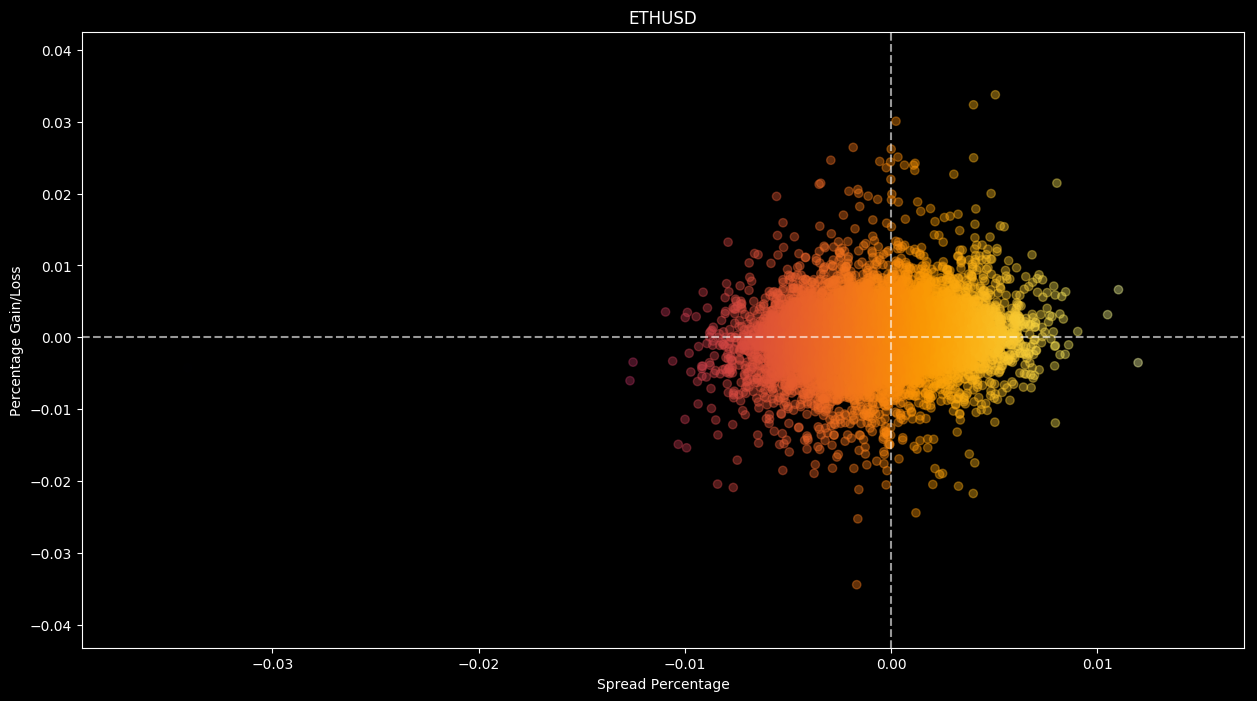

In [86]:
lookahead = 5
plt.style.use('dark_background') # black background

for asset in asset_col:
    spread_name = asset + '_spread'
    spread_x = []
    spread_pct_sum = []
    
    for index in std_spread[spread_name].dropna().index:
        spread_data = std_spread[spread_name].loc[index]
        spread_sum = assets[asset].loc[index:index+timedelta(minutes=lookahead)].sum()
        
        spread_x.append(spread_data)
        spread_pct_sum.append(spread_sum)
    
    plt.figure()
    plt.scatter(spread_x, spread_pct_sum, c=spread_x, cmap='inferno', alpha=0.4)
    plt.title(asset)
    plt.ylabel('Percentage Gain/Loss')
    plt.xlabel('Spread Percentage')
    
    plt.axhline(0.00, c='#ffffff', alpha=0.6, linestyle='--')
    plt.axvline(0.00, c='#ffffff', alpha=0.6, linestyle='--')

Nothing distinguishable here. Maybe screening via autocorrelation or volatility might be the way to go to perhaps ehnace statistical significance. 

I will revisit this at a later date. 

**EOF**